<h1><center><font size="6">Honey Bee Subspecies Classification</font></center></h1>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Bee-apis.jpg/337px-Bee-apis.jpg"></img><center>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
 - <a href='#21'>Load packages</a>  
 - <a href='#21'>Load the data</a>  
 - <a href='#21'>Preprocessing data</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check for missing data</a>  
 - <a href='#32'>Explore image data</a>  
 - <a href='#33'>Location</a>  
 - <a href='#34'>Date and Time</a>  
 - <a href='#35'>Subspecies</a>  
  - <a href='#36'>Health</a>  
  - <a href='#37'>Pollen carrying</a>  
  - <a href='#38'>Caste</a>  
- <a href='#4'>Subspecies classification</a>  
 - <a href='#40'>Split the data</a>  
 - <a href='#41'>Build a baseline model</a>  
 - <a href='#42'>Model evaluation</a>    
 - <a href='#43'>Add Dropout</a>  
 - <a href='#44'>Model refinement</a>  
- <a href='#6'>Conclusions</a>    
- <a href='#7'>References</a>    

# <a id='1'>Introduction</a>  


In this Kernel, we will explore a dataset with adnotated images of bees from various locations of US, captured over several months during 2018, at different hours, from various bees subspecies, and with different health problems. 

The objective of the Kernel is to take us through the steps of a machine learning analysis.   
We start by preparing the analysis (load the libraries and the data), continue with an Exploratory Data Analysis (EDA) where we highlight various data features, spending some time to try to understand the data and also get an idea about various features predictive potential and correlation with other features.   
We follow then with features engineering and preparation for creation of a model. The dataset is split in training, validation and test set. We start then with a simple model to classify the bees subspecies, something we are calling a baseline model.   
We evaluate the model, estimating the training error and accuracy and also the validation error and accuracy. With these, and with an rough estimate of what will be the (human) error rate for classification of bees subspecies, we decide how to follow our machine learning for image classification work. If we have at start a high bias, we will try first to improve our model so that will learn better the train images dataset. If we have a small bias but large variance (the model learns well the training data but fails to generalize, that means our model is overfitting. Based on these kind of observation, we make decission for how to adjust the model.   
We run few models with the improvements decided based on analysis or error and accuracy and we decide at the end for a final model. This model will be used for classification of fresh, new data, not used for training or validation, the test set.

Note: this Kernel is using GPU acceleration. If you will fork and run, this will require few minutes of GPU run from your 30 h/week free GPU quota.

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='2'>Prepare the data analysis</a>   


Before starting the analysis, we need to make few preparation: load the packages, load and inspect the data.



# <a id='21'>Load packages</a>

We load the packages used for the analysis.


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow

print("Done")

Done


In [12]:
IMAGE_PATH = 'bee_imgs/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

print("Done")

Done


<a href="#0"><font size="1">Go to top</font></a>  


# <a id='22'>Load the data</a>

There is a dataset file and a folder with images.  

Let's load the dataset file first.

In [7]:
honey_bee_df=pd.read_csv('bee_data.csv')

print("Done")

Done


Let's glimpse the data. First, let's check the number of columns and rows.

In [8]:
honey_bee_df.shape

(5172, 9)

There are 5172 rows and 9 columns. Let's look to the data.

In [9]:
honey_bee_df.sample(100).head()

file     date   time           location  zip code  \
4997  035_043.png  8/21/18  15:56    Athens, GA, USA     30607   
804   030_831.png  8/17/18  17:50     Alvin, TX, USA     77511   
1967  002_054.png  8/25/18  14:00     Keene, NH, USA      3431   
1118  030_647.png  8/17/18  17:50     Alvin, TX, USA     77511   
3243  015_259.png   8/6/18  13:19  Saratoga, CA, USA     95070   

             subspecies                    health  pollen_carrying   caste  
4997  Italian honey bee  few varrao, hive beetles            False  worker  
804   Italian honey bee              ant problems            False  worker  
1967  Russian honey bee                   healthy            False  worker  
1118  Italian honey bee              ant problems            False  worker  
3243  Italian honey bee                   healthy            False  worker

The data contains the following values:  

* file - the image file name;  
* date - the date when the picture was taken;
* time - the time when the picture was taken;
* location - the US location, with city, state and country names;  
* zip code - the ZIP code associated with the location;  
* subspecies - the subspecies to whom the bee in the current image belongs;  
* health - this is the health state of the bee in the current image;  
* pollen_carrying - indicates if the picture shows the bee with pollen attached to the legs;  
* caste - the bee caste;  

It is important, before going to create a model, to have a good understanding of the data. We will therefore explore the various features, not only the images.

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='3'>Data exploration</a>  



Let's start by checking if there are missing data, unlabeled data or data that is inconsistently labeled. 


## <a id='31'>Check for missing data</a>  

Let's create a function that check for missing data in the dataset.

In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(honey_bee_df)

print("Done")

Done


There is no missing (null) data in the dataset. Still it might be that some of the data labels are misspelled; we will check this when we will analyze each data feature.

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='32'>Explore image data</a>  

Let's also check the image data. First, we check how many images are stored in the image folder.

In [13]:
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5172


Let's also check that each line in the dataset has a corresponding image in the image list.

In [14]:
file_names = list(honey_bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


Let's also check the image sizes.

In [15]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

print("Done")

Done


In [16]:
m = np.stack(honey_bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c'])
honey_bee_df = pd.concat([honey_bee_df,df],axis=1, sort=False)

print("Done")

Done


Let's represent the distribution of the images sizes (width and height).

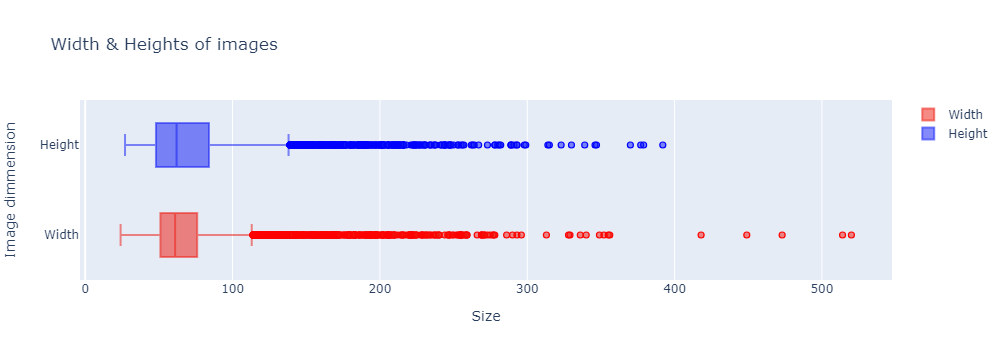

In [17]:
traceW = go.Box(
    x = honey_bee_df['w'],
    name="Width",
     marker=dict(
                color='rgba(238,23,11,0.5)',
                line=dict(
                    color='red',
                    width=1.2),
            ),
    orientation='h')
traceH = go.Box(
    x = honey_bee_df['h'],
    name="Height",
    marker=dict(
                color='rgba(11,23,245,0.5)',
                line=dict(
                    color='blue',
                    width=1.2),
            ),
    orientation='h')
data = [traceW, traceH]
layout = dict(title = 'Width & Heights of images',
          xaxis = dict(title = 'Size', showticklabels=True), 
          yaxis = dict(title = 'Image dimmension'),
          hovermode = 'closest',
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='width-height')

We will also load images associated with each features categories, in the following sections.

## <a id='33'>Locations</a>  

Let's check the locations of the images. For this, we will group by `location` and `zip code`.

In [18]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

zip code              location  Images
0      3431        Keene, NH, USA      92
1     30607       Athens, GA, USA     579
2     30607  Athens, Georgia, USA     472
3     50315   Des Moines, IA, USA     973
4     70115  New Orleans, LA, USA     170
5     77511        Alvin, TX, USA     737
6     95070     Saratoga, CA, USA    2000
7     95124     San Jose, CA, USA     149

We observe that `Athens, GA, USA` is actually the same location as `Athens, Georgia, USA`, only written differently (the `zip code` is the same as well). Let's modify the data to have the same location name for both.

In [19]:
honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

print("Done")

Done


In [20]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df['code'] = df['location'].map(lambda x: x.split(',', 2)[1])
df

print("Done")

Done


Let's visualize now the **location** data.

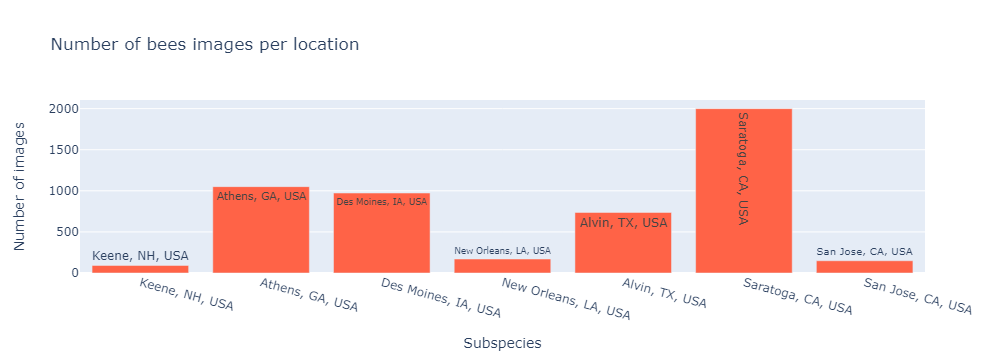

In [21]:
trace = go.Bar(
        x = df['location'],
        y = df['Images'],
        marker=dict(color="Tomato"),
        text=df['location']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per location',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-location')

Most of the images (2000) were captured in `Saratoga, California`. On second place is `Athens, Georgia` (1051), followed by `Des Moines, Iowa` (973).   

Let's load few images, one per each location.

In [23]:
#list of locations
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index

print("Done")

Done


In [25]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

print("Done")

Done


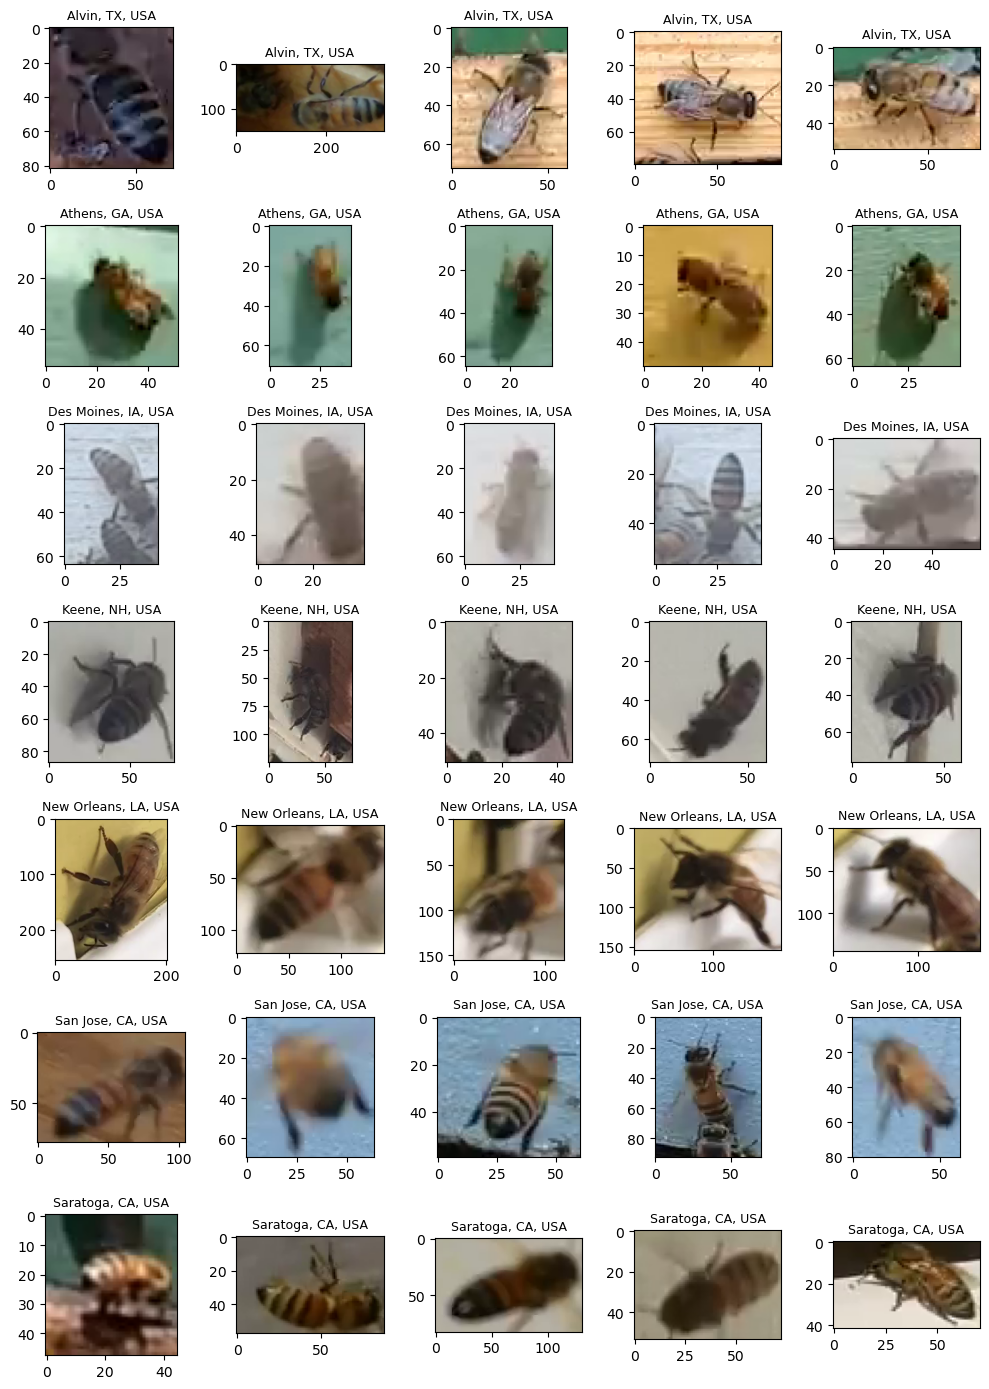

In [26]:
draw_category_images("location")

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='34'>Date and time</a>   

Let's first convert date to datetime and extract year, month and day.  We also convert time and extract hour and minute.

In [27]:
honey_bee_df['date_time'] = pd.to_datetime(honey_bee_df['date'] + ' ' + honey_bee_df['time'])
honey_bee_df["year"] = honey_bee_df['date_time'].dt.year
honey_bee_df["month"] = honey_bee_df['date_time'].dt.month
honey_bee_df["day"] = honey_bee_df['date_time'].dt.day
honey_bee_df["hour"] = honey_bee_df['date_time'].dt.hour
honey_bee_df["minute"] = honey_bee_df['date_time'].dt.minute

print("Done")

Done


Let's plot the date/time distribution of the data. We group the data on `date_time` and count the images. We will represent the date on x-axis, the time (with hours resolution) on y-axis, and one circle with area proportional with the number of images taken for each location corresponding to the date and hour.

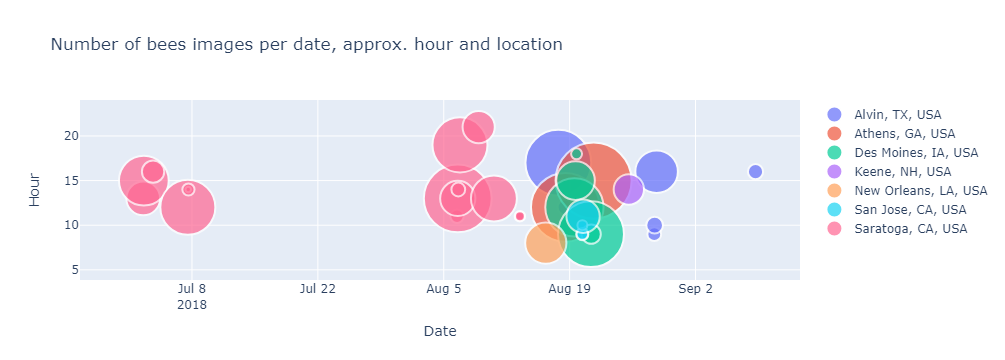

In [28]:
tmp = honey_bee_df.groupby(['date_time', 'hour'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Date/time: {}<br>'+
                      'Hour: {}<br>'+
                      'Location: {}<br>'+
                      'Images: {}').format(row['date_time'],
                                            row['hour'],
                                            row['location'],
                                            row['Images']))
df['hover_text'] = hover_text
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index
data = []
for location in locations:
    dfL = df[df['location']==location]
    trace = go.Scatter(
        x = dfL['date_time'],y = dfL['hour'],
        name=location,
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=0.2,
            size=dfL['Images'],
            line=dict(
                width=2
            ),),
        mode = "markers",
        text=dfL['hover_text'],
    )
    data.append(trace)
    
layout = dict(title = 'Number of bees images per date, approx. hour and location',
          xaxis = dict(title = 'Date', showticklabels=True), 
          yaxis = dict(title = 'Hour'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)

iplot(fig, filename='images-date_time')

Let's also show now a number of images per each day **hour**.

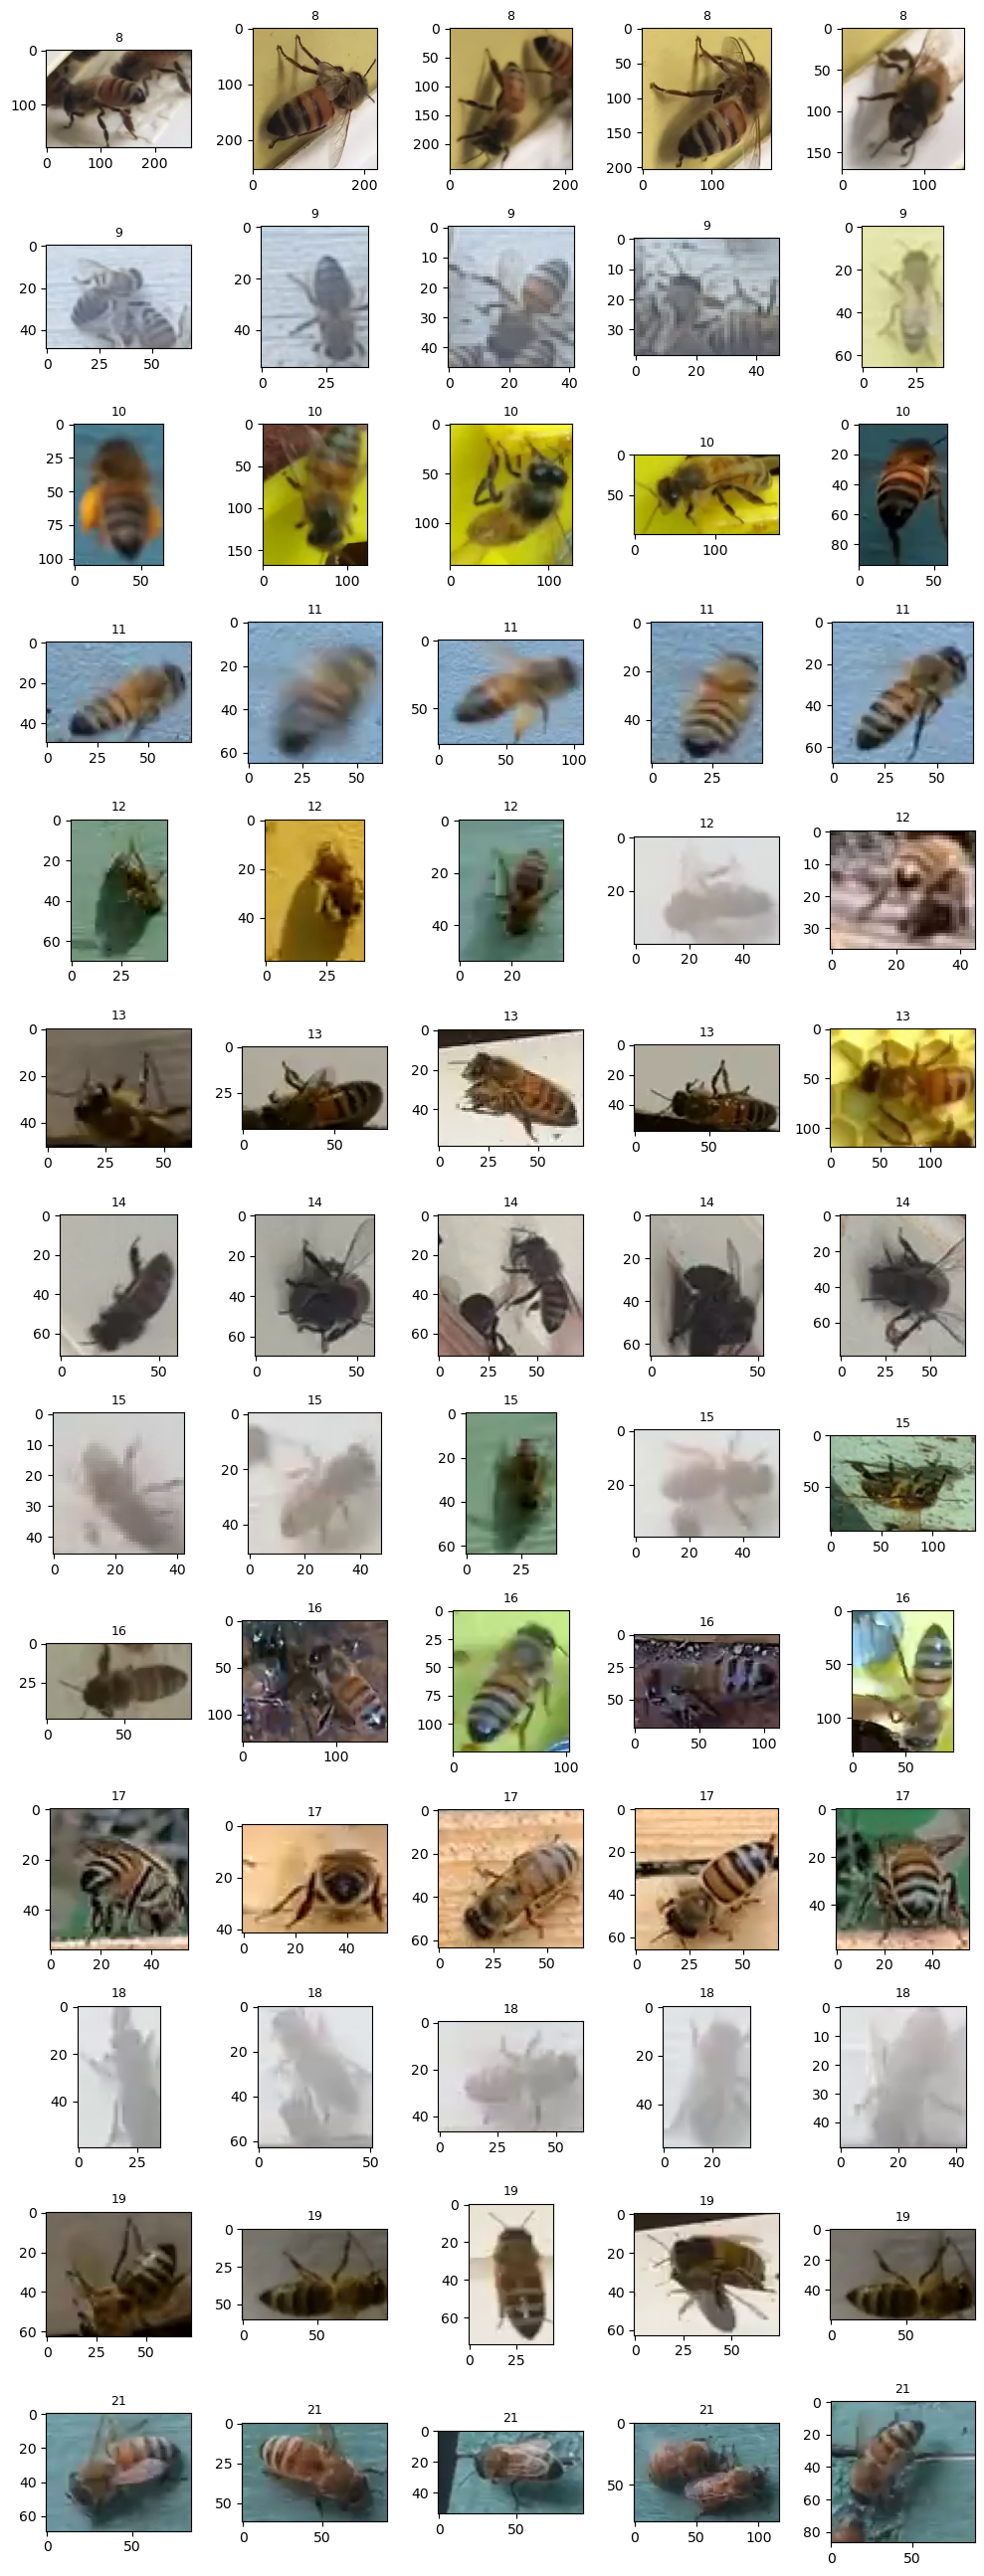

In [29]:
draw_category_images("hour")

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='34'>Subspecies</a>   

Let's plot now the subspecies distribution.

In [30]:
tmp = honey_bee_df.groupby(['subspecies'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

print("Done")

Done


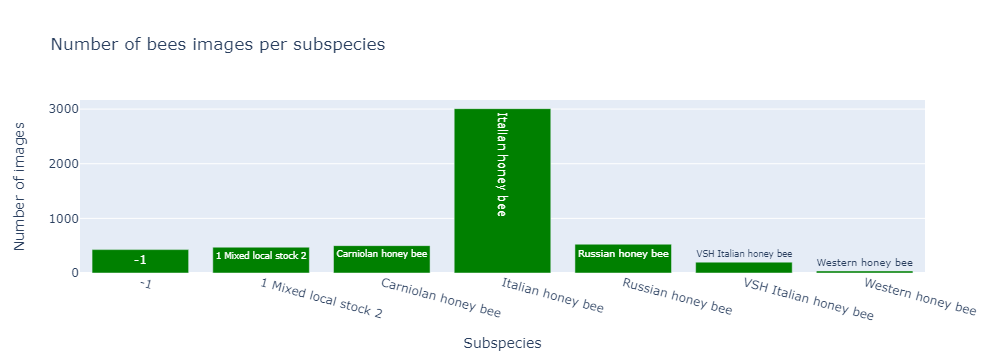

In [31]:
trace = go.Bar(
        x = df['subspecies'],
        y = df['Images'],
        marker=dict(color="Green"),
        text=df['subspecies']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per subspecies',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-subspecies')

The majority of subspecies are `Italian honey bee`,  with 3008 images, followed by `Russian honey bee` (527) and `Carniolan honey bee` (501). There is a relativelly large number of subspecies not identified, marked with `-1` (428).

Let's show few images of each **subspecies**.

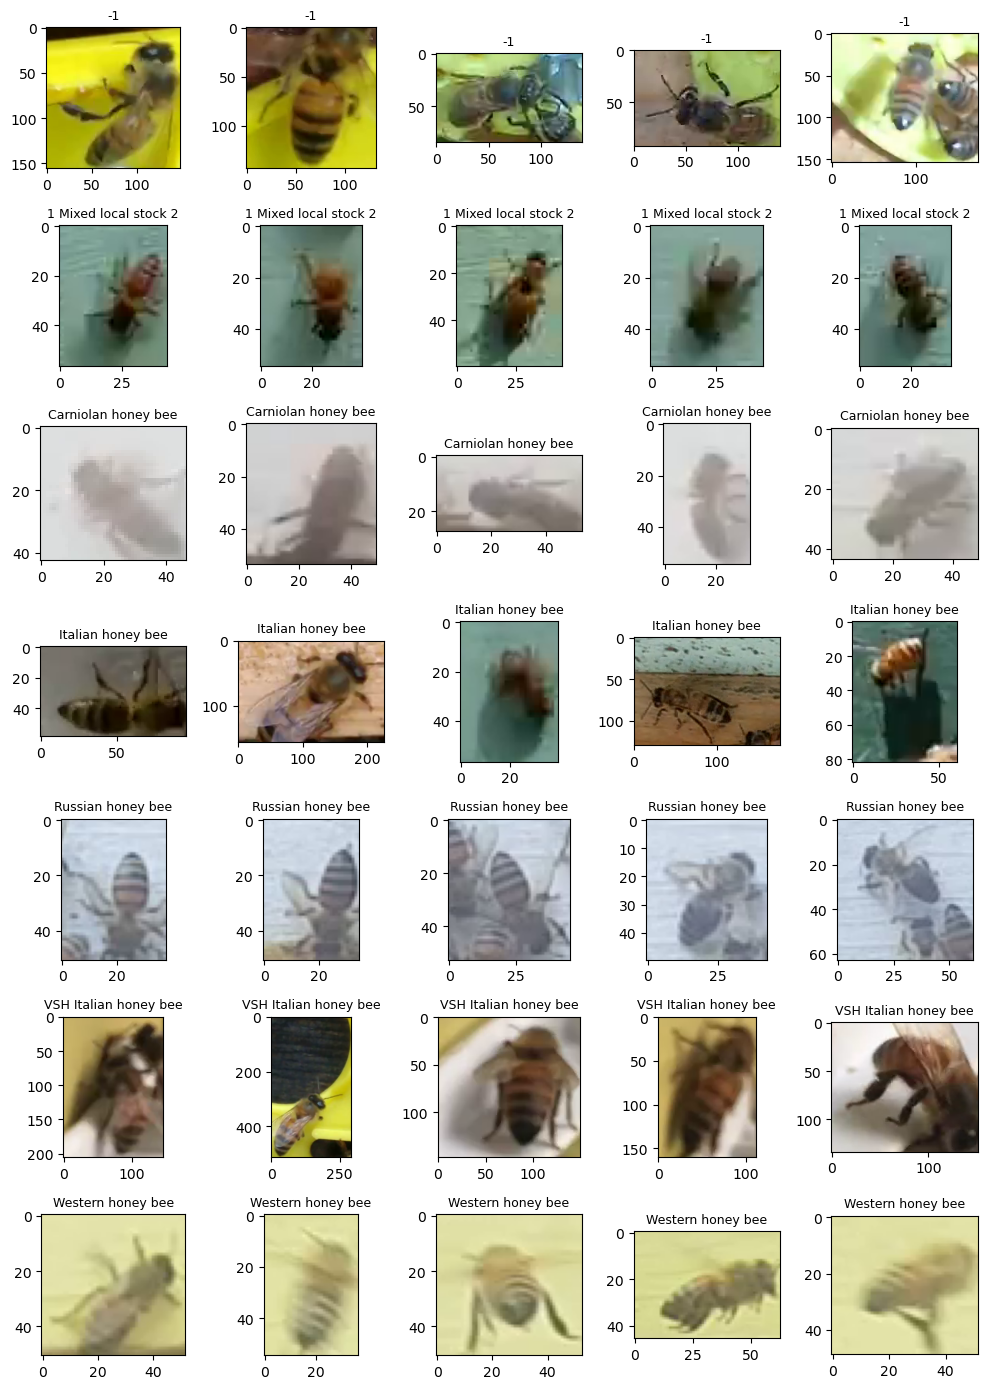

In [32]:
draw_category_images("subspecies")

### Subspecies and location

In [33]:
tmp = honey_bee_df.groupby(['subspecies'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()

print("Done")

Done


In [34]:
piv = pd.pivot_table(df, values="Images",index=["subspecies"], columns=["location"], fill_value=0)
m = piv.values

print("Done")

Done


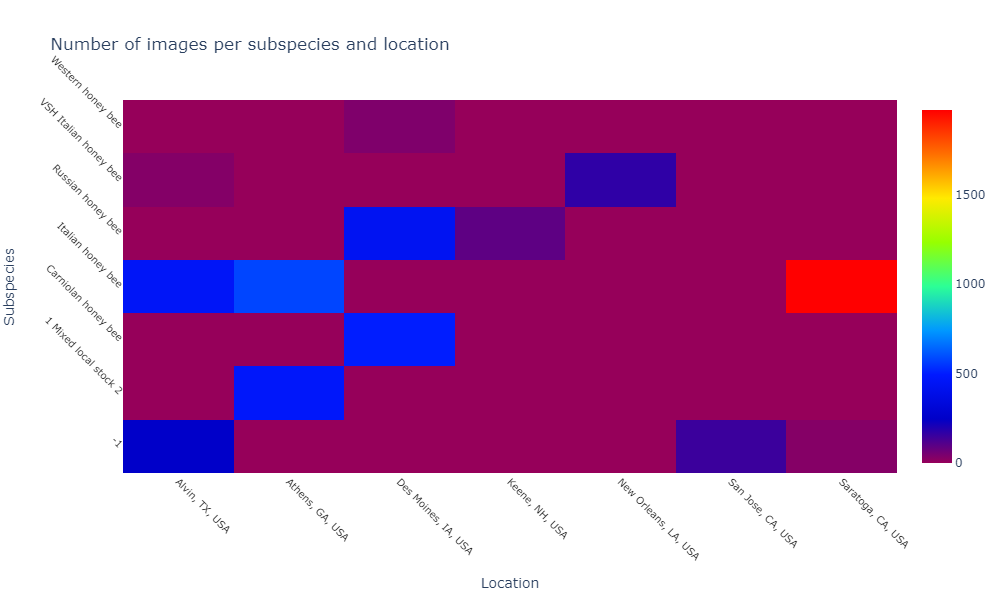

In [35]:
trace = go.Heatmap(z = m, y= list(piv.index), x=list(piv.columns),colorscale='Rainbow',reversescale=False)
    
data=[trace]
layout = dict(title = "Number of images per subspecies and location",
              xaxis = dict(title = 'Location',
                        showticklabels=True,
                           tickangle = 45,
                        tickfont=dict(
                                size=10,
                                color='black'),
                          ),
              yaxis = dict(title = 'Subspecies', 
                        showticklabels=True, 
                           tickangle = 45,
                        tickfont=dict(
                            size=10,
                            color='black'),
                      ), 
              hovermode = 'closest',
              showlegend=False,
                  width=600,
                  height=600,
             )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-location_subspecies')

### Subspecies and hour

In [36]:
tmp = honey_bee_df.groupby(['subspecies'])['hour'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()

print("Done")

Done


In [37]:
piv = pd.pivot_table(df, values="Images",index=["subspecies"], columns=["hour"], fill_value=0)
m = piv.values

print("Done")

Done


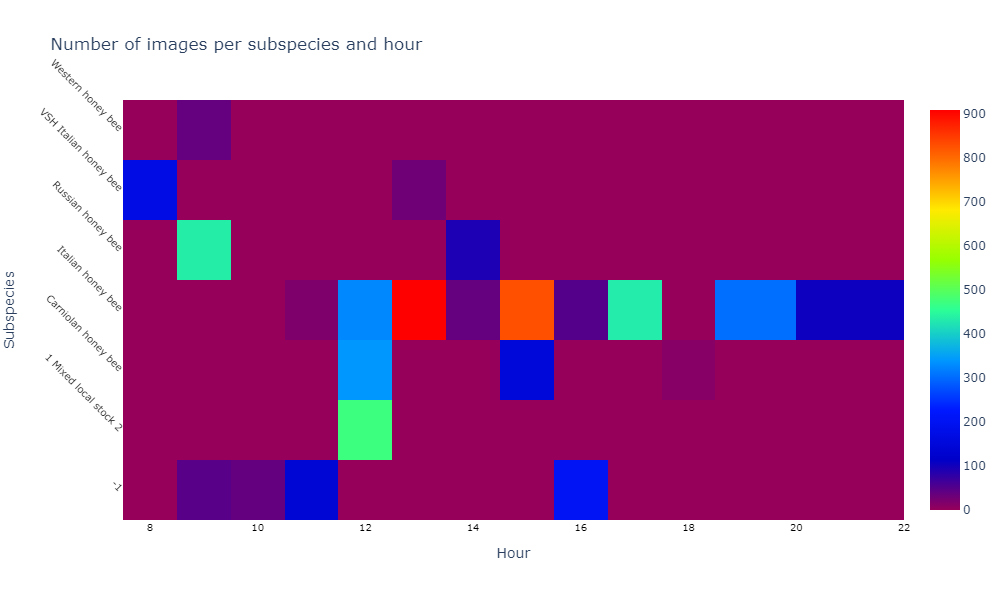

In [38]:
trace = go.Heatmap(z = m, y= list(piv.index), x=list(piv.columns),colorscale='Rainbow',reversescale=False)
    
data=[trace]
layout = dict(title = "Number of images per subspecies and hour",
              xaxis = dict(title = 'Hour',
                        showticklabels=True,
                           tickangle = 0,
                        tickfont=dict(
                                size=10,
                                color='black'),
                          ),
              yaxis = dict(title = 'Subspecies', 
                        showticklabels=True, 
                           tickangle = 45,
                        tickfont=dict(
                            size=10,
                            color='black'),
                      ), 
              hovermode = 'closest',
              showlegend=False,
                  width=600,
                  height=600,
             )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-location_subspecies')

### Subspecies and image size 

Let's draw the image size distribution (width and height) grouped by subspecies.

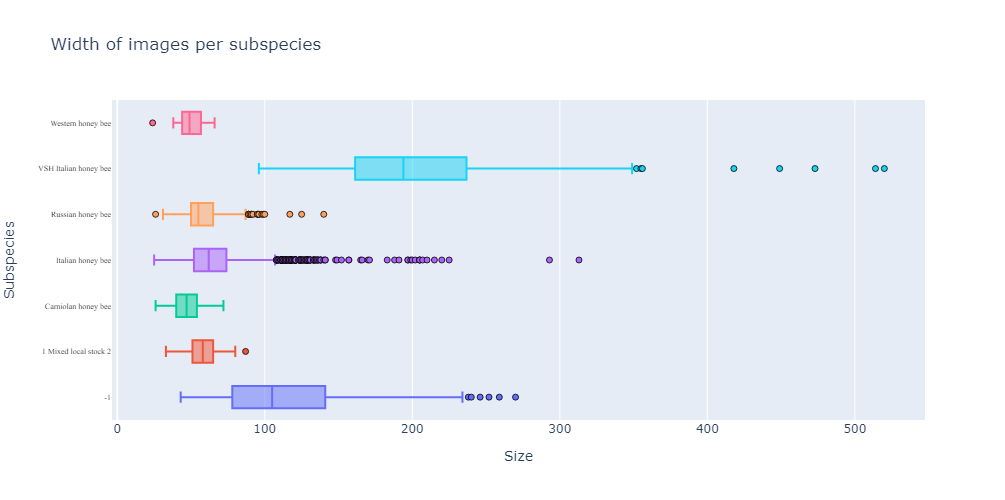

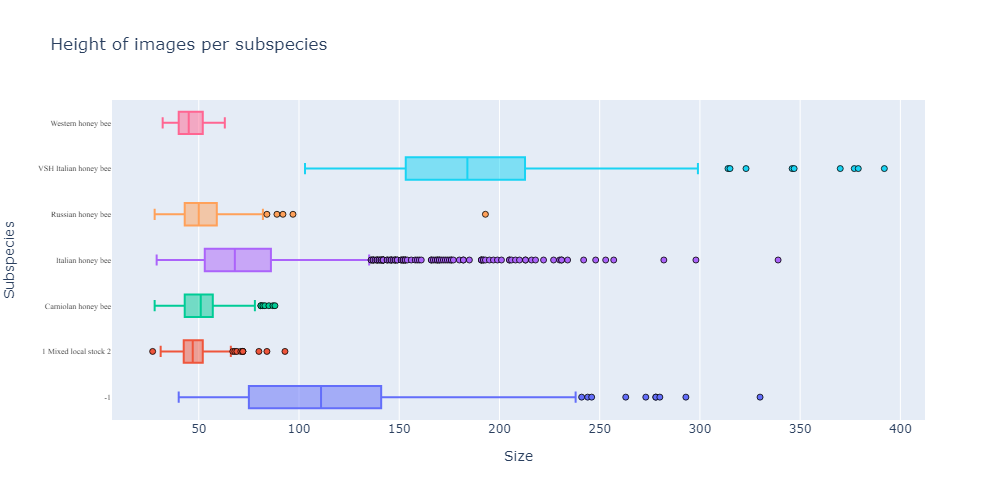

In [39]:
def draw_trace_box(dataset,var, subspecies):
    dfS = dataset[dataset['subspecies']==subspecies];
    trace = go.Box(
        x = dfS[var],
        name=subspecies,
        marker=dict(
                    line=dict(
                        color='black',
                        width=0.8),
                ),
        text=dfS['subspecies'], 
        orientation = 'h'
    )
    return trace

subspecies = (honey_bee_df.groupby(['subspecies'])['subspecies'].nunique()).index
def draw_group(dataset, var, title,height=500):
    data = list()
    for subs in subspecies:
        data.append(draw_trace_box(dataset, var, subs))
        
    layout = dict(title = title,
              xaxis = dict(title = 'Size',showticklabels=True),
              yaxis = dict(title = 'Subspecies', showticklabels=True, tickfont=dict(
                family='Old Standard TT, serif',
                size=8,
                color='black'),), 
              hovermode = 'closest',
              showlegend=False,
                  width=600,
                  height=height,
             )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='subspecies-image')


draw_group(honey_bee_df, 'w', "Width of images per subspecies")
draw_group(honey_bee_df, 'h', "Height of images per subspecies")

We see that the averages values for the images sizes are between 50 and 100 pixels and the extreme values are from few pixels to approximatelly 500. We will scale all images to 100 x 100 pixels.

Let's draw as well the scatter plot of the image width and height, grouped by subspecies.

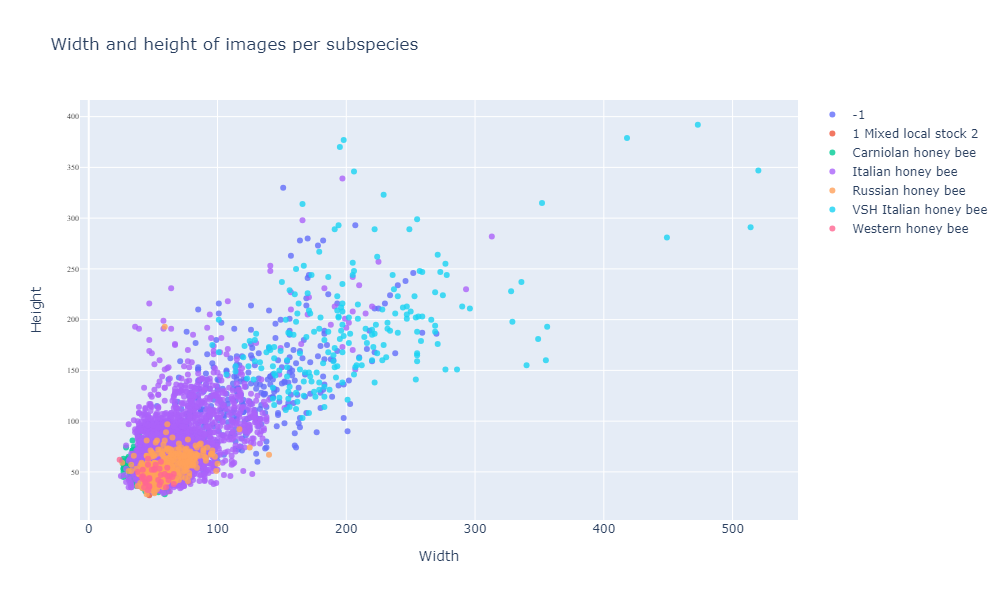

In [40]:
def draw_trace_scatter(dataset, subspecies):
    dfS = dataset[dataset['subspecies']==subspecies];
    trace = go.Scatter(
        x = dfS['w'],y = dfS['h'],
        name=subspecies,
        mode = "markers",
        marker = dict(opacity=0.8),
        text=dfS['subspecies'], 
    )
    return trace

subspecies = (honey_bee_df.groupby(['subspecies'])['subspecies'].nunique()).index
def draw_group(dataset, title,height=600):
    data = list()
    for subs in subspecies:
        data.append(draw_trace_scatter(dataset, subs))
        
    layout = dict(title = title,
              xaxis = dict(title = 'Width',showticklabels=True),
              yaxis = dict(title = 'Height', showticklabels=True, tickfont=dict(
                family='Old Standard TT, serif',
                size=8,
                color='black'),), 
              hovermode = 'closest',
              showlegend=True,
                  width=800,
                  height=height,
             )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='subspecies-image')


draw_group(honey_bee_df,  "Width and height of images per subspecies")

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='35'>Health</a>   

Let's plot now the health distribution.

In [41]:
tmp = honey_bee_df.groupby(['health'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

print("Done")

Done


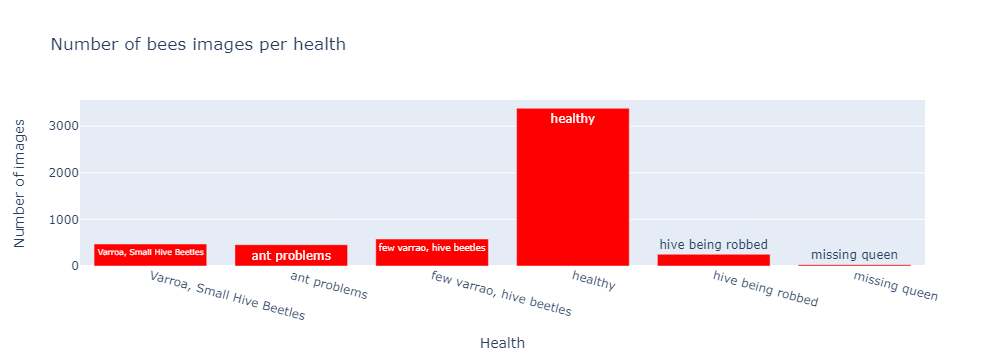

In [42]:
trace = go.Bar(
        x = df['health'],
        y = df['Images'],
        marker=dict(color="Red"),
        text=df['health']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per health',
          xaxis = dict(title = 'Health', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-health')

Majority of images are for healthy bees (3384), followed by `few varrao, hive beetles` (579) and `Varroa, Small Hive Beetles` (472) and `ant problems` (457).

Let's plot on the same graph subspecies and health.

In [43]:
tmp = honey_bee_df.groupby(['subspecies'])['health'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

print("Done")

Done


In [44]:
piv = pd.pivot_table(df, values="Images",index=["subspecies"], columns=["health"], fill_value=0)
m = piv.values

print("Done")

Done


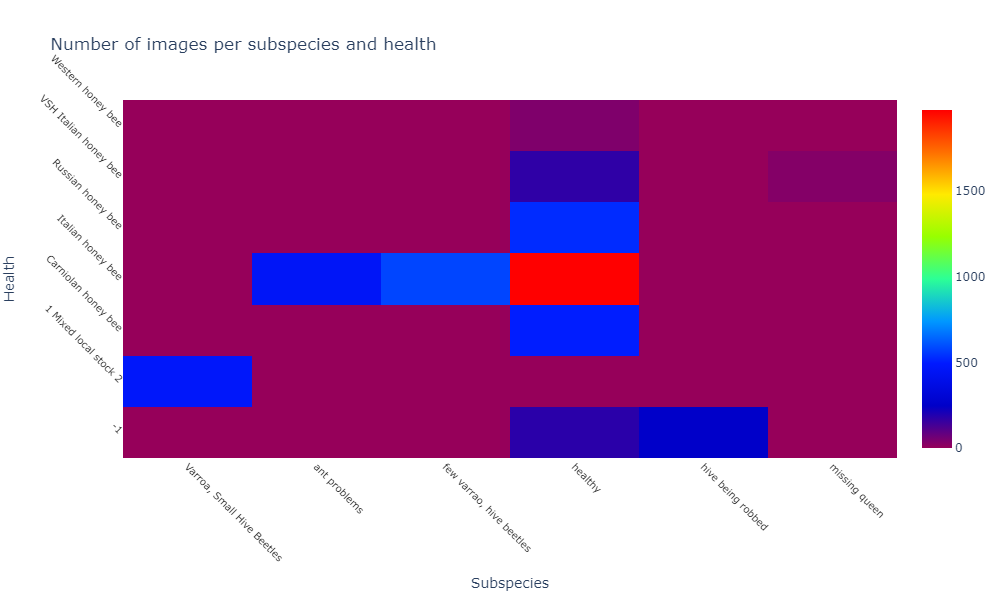

In [45]:
trace = go.Heatmap(z = m, y= list(piv.index), x=list(piv.columns),colorscale='Rainbow',reversescale=False)
    
data=[trace]
layout = dict(title = "Number of images per subspecies and health",
              xaxis = dict(title = 'Subspecies',
                        showticklabels=True,
                           tickangle = 45,
                        tickfont=dict(
                                size=10,
                                color='black'),
                          ),
              yaxis = dict(title = 'Health', 
                        showticklabels=True, 
                           tickangle = 45,
                        tickfont=dict(
                            size=10,
                            color='black'),
                      ), 
              hovermode = 'closest',
              showlegend=False,
                  width=600,
                  height=600,
             )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-health_subspecies')

Only a reduced number of combination of health and subspecies values are present. The majority of images are of `healthy` `Italian honey bee` (1972), followed by `few varrao, hive beetles`  `Italian honey bee` (579) and  `healthy` `Russian honey bee` (527). The unknown subspecies are either `healthy` (177) or `hive being robbed` (251).   

Let's plot on the same graph the number of images per location and health, grouped by subspecies.


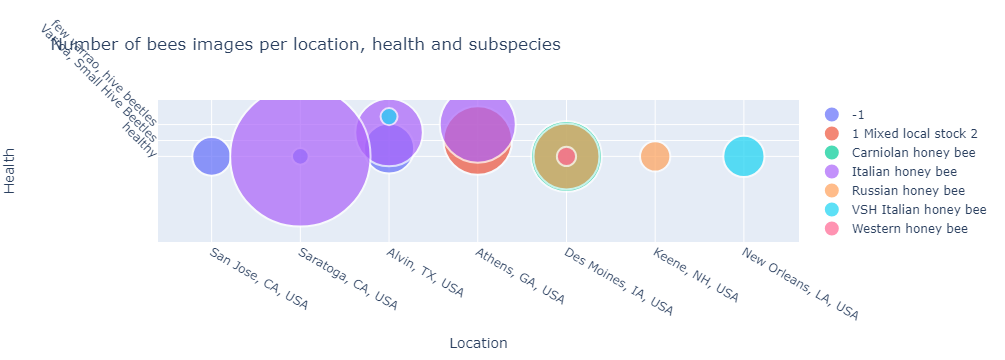

In [46]:
tmp = honey_bee_df.groupby(['health', 'location'])['subspecies'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Subspecies: {}<br>'+
                      'Health: {}<br>'+
                      'Location: {}<br>'+
                      'Images: {}').format(row['subspecies'],
                                            row['health'],
                                            row['location'],
                                            row['Images']))
df['hover_text'] = hover_text
subspecies = (honey_bee_df.groupby(['subspecies'])['subspecies'].nunique()).index
data = []
for subs in subspecies:
    dfL = df[df['subspecies']==subs]
    trace = go.Scatter(
        x = dfL['location'],y = dfL['health'],
        name=subs,
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=0.2,
            size=dfL['Images'],
            line=dict(
                width=2
            ),),
        mode = "markers",
        text=dfL['hover_text'],
    )
    data.append(trace)
    
layout = dict(title = 'Number of bees images per location, health and subspecies',
          xaxis = dict(title = 'Location', showticklabels=True), 
          yaxis = dict(title = 'Health', tickangle=45),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-subspecies-health-location')

Let's plot few images for each **health** category.

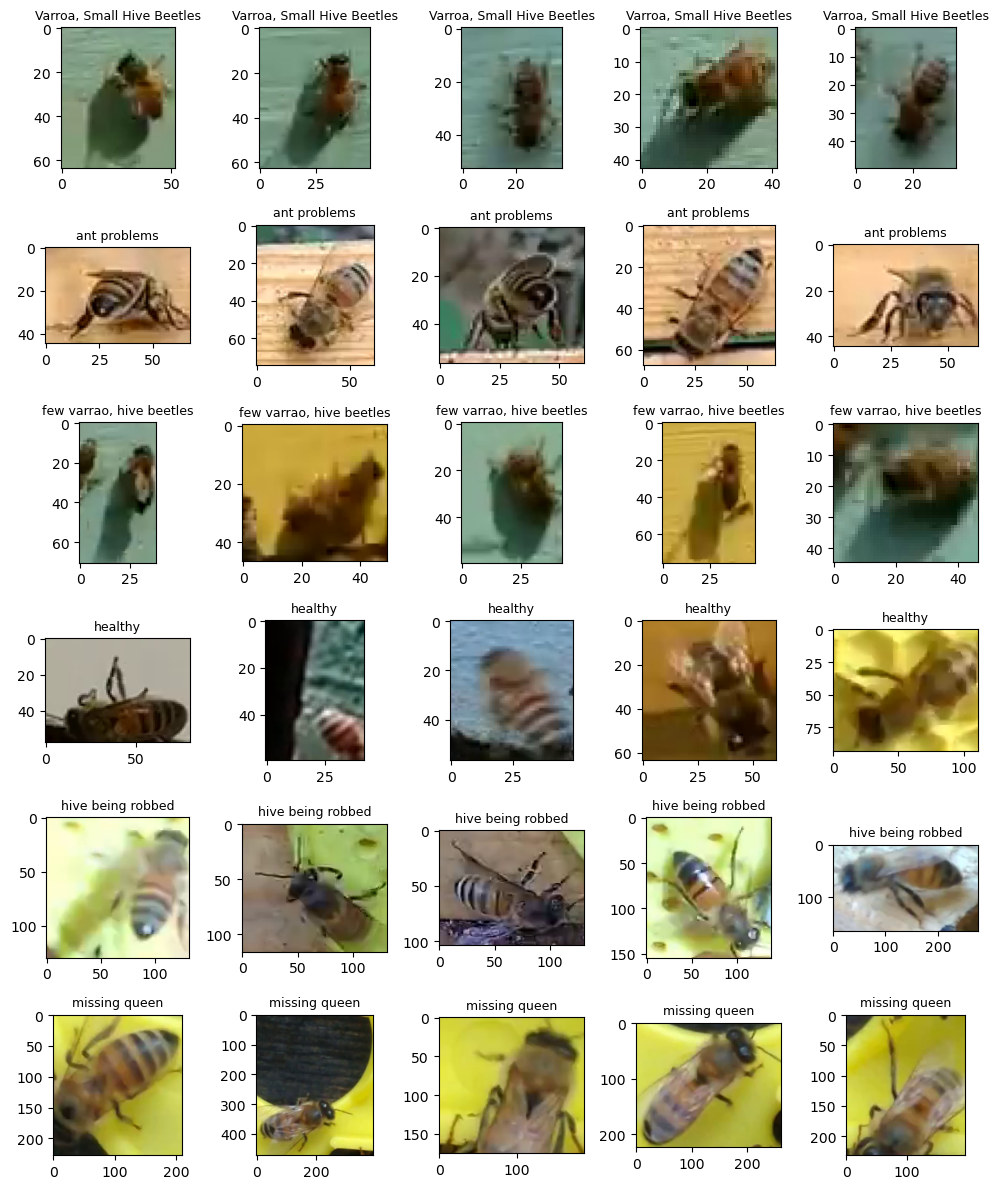

In [47]:
draw_category_images("health")

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='36'>Pollen carying</a>   

Let's check now the pollen carying distribution.

In [48]:
tmp = honey_bee_df.groupby(['pollen_carrying'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

print("Done")

Done


Only 18 out of 5172 (0.34%) of the images are of bees carrying pollen. We will not try to predict this, as the data is highly unballanced. Let's see what species have pollen carrying.

In [49]:
tmp = honey_bee_df.groupby(['pollen_carrying'])['subspecies'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df[df['pollen_carrying']==True]

print("Done")

Done


Majority of pollen carrying bees are of unknown species (67%) and the rest (33%) are `Italian honey bee`.  

Let's plot few images with honey bees either **carrying pollen** or not.

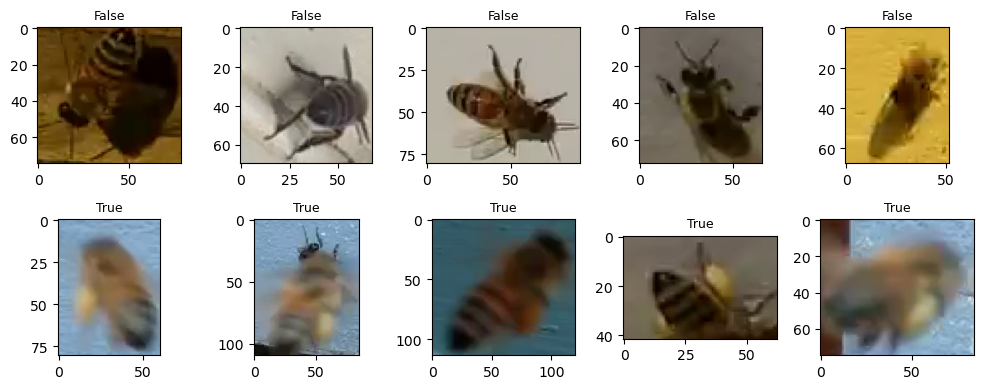

In [50]:
draw_category_images("pollen_carrying")

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='37'>Caste</a>   

Let's check now the`Caste` distribution.

In [51]:
honey_bee_df.groupby(['caste'])['caste'].nunique()

caste
worker    1
Name: caste, dtype: int64

All the bees are of `worker` caste.   



<a href="#0"><font size="1">Go to top</font></a>  

# <a id='4'>Subspecies classification</a>

Our objective is to use the images that we investigated until now to correctly identify the subspecies. We have a unique dataset and we will have to split this dataset in **train** and **test**. The **train** set will be used for training a model and the test will be used for testing the model accuracy against new, fresh data, not used in training.



## <a id='40'>Split the data</a>  

First, we split the whole dataset in train and test. We will use **random_state** to ensure reproductibility of results.   

The train-test split is **80%** for training set and **20%** for test set.


In [ ]:
train_df, test_df = train_test_split(honey_bee_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, 
                                     stratify=honey_bee_df['subspecies'])

Next, we will split further the **train** set in **train** and **validation**. We want to use as well a validation set to be able to measure not only how well fits the model the train data during training (or how well `learns` the training data) but also how well the model is able to generalize so that we are able to understands not only the bias but also the variance of the model.  

The train-validation split is **80%** for training set and **20%** for validation set.

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df['subspecies'])

Let's check the shape of the three datasets.

In [ ]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

We are now ready to start building our first model.

## <a id='41'>Build a baseline model</a>    


Next step in our creation of a predictive model is to create a simple model, a **baseline model**.  

 Why start with a simple model (as simple as possible, but not simpler :-) )?
 
 With a simple model, we can get fast insight in how well will the data predict our target value. Looking to the training results (the training error and accuracy, the validation error and accuracy), we can understand if we need to add more data (because the training accuracy is small) or if we need to optimize the model (by adding more convolutional layers) or if we need to add Dropout layers (because the validation error is increasing after few steps - the model is overfitting) etc.
 
Let's define few auxiliary functions that we will need for creation of our models.

A function for reading images from the image files, scale all images to 100 x 100 x 3 (channels).

In [ ]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

A function to create the dummy variables corresponding to the categorical target variable.

In [ ]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

Let's populate now the train, val and test sets with the image data and create the  dummy variables corresponding to the categorical target variable, in our case `subspecies`.

In [ ]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

Now we are ready to start creating our model.  

We will add the folllowing elements to our model: 
* One convolutional layer, with 16 filters of dimmension 3;  
* One maxpoll2d layer, with reduction factor 2;  
* One convolutional layer, with 16 filters of dimmension 3;  
* A flatten layer;  
* A dense layer;  

In [ ]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

We are also using a **ImageDataGenerator** that creates random variation of the training dataset, by applying various techniques, including:
* rotation (in a range of 0-180 degrees) of the original images;  
- zoom (10%);  
- shift in horizontal and in vertical direction (10%);  
- horizontal and vertical flip;  


In [ ]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

We train the first model using **fit_generator** and a predefined batch size. The **steps_per_epoch** is calculated to be size of the training set divided by the batch size. We are using the predefined epoch number for this first experiment (5 steps) and as well validation, using the validation set. 

In [ ]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

<a href="#0"><font size="1">Go to top</font></a>  


## <a id='42'>Model evaluation</a> 


Let's start by plotting the loss error for the train and validation set. 
We define a function to visualize these values.

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model1)


Let's continue by evaluating the **test** set **loss** and **accuracy**. We will use here the test set.

In [ ]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Let's check also the test accuracy per class.

In [ ]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [ ]:
test_accuracy_report(model1)

We used a simple model. We separated 20% of the data for testing. From the training data, 80% is used for actual training and 20% for testing.   
The data is unbalanced with respect of the classes of subspecies.   
The accuracy of the training set obtained after only 5 epochs was 0.84, with a loss of 0.38.    
The accuracy of the validation set remained around 0.84 and the loss remained constant after epoch 4.  

Adding additional data will only slightly increase the accuracy of the training set (it is already very good).   
To reduce the loss of the validation set (which is a sign of overfitting), we can have three strategies:  
* add Dropout layers;  
* introduce strides;  
* modify the learning rate during the training;  


<a href="#0"><font size="1">Go to top</font></a>  


## <a id='43'>Add Dropout</a>  

We add two Dropout layers.  The role of the Dropout layers is to reduce the overfitting, by dropping, each training epoch, a certain percent of the nodes connections (by rotation). This is equivalent of using less training data and in the same time training the network with various data as well as using `parallel` alternative networks, thus reducing the likelihood that the network will overfit the train data.  

The definition of the second model is:

In [ ]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's inspect the new model.

In [ ]:
model2.summary()

We can observe that this model has the same number of parameters and trainable parameters as  the previous model.

In [ ]:
train_model2  = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

### Evaluate model accuracy and loss

In [ ]:
plot_accuracy_and_loss(train_model2)

### Test accuracy and loss

Let's evaluare as well the test accuracy and loss.

In [ ]:
test_accuracy_report(model2)

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='45'>Model refinement</a>  


We define now also a refined model. 

We add an early stopping condition (monitor the loss error and stops the training if for a number of stept given in the `patience` parameters the loss is not improving).

We are also saving a model checkpoint after each epoch when accuracy improves; if accuracy degrades, no new model is saved. Thus, Model Checkpoint saves all the time the best model in terms of accuracy.  

We adjust as well the learning rate with the training epochs.

Also, we increase the number of training epochs to 50.



In [ ]:
annealer3 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper3 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
model3=Sequential()
model3.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model3.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(y_train.columns.size, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's inspect the refined model.

In [ ]:
model3.summary()

Now, let's train the model.

In [ ]:
train_model3  = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper3, checkpointer3, annealer3])

### Model accuracy and loss

In [ ]:
plot_accuracy_and_loss(train_model3)

### Test accuracy and loss

In [ ]:
test_accuracy_report(model3)

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='6'>Conclusions</a>  

After exploring the data to understand its various features, a baseline model is created.   
Evaluation of the baseline model  results for valid set and test set allows us to decide, based on analysis of bias and variance, how to conduct furher our experiments.

From the possible solutions for overfitting, we choose to add Dropout layers. Adding Dropout layers improve a bit the algorithm performance (reduce overfitting).  

A third model, with adjustable learning rate, early stoping based on validation accuracy measurement and saving the model with best accuracy was also created. With this model, accuracy of prediction for the test set was further improved.

The key lessons learned from this Kernel are the following:   

* start by analyzing the data;   
* follow with a simple baseline model;   
* refine gradually the model, by making corrections based on the analysis of the (partial) results.

<a href="#0"><font size="1">Go to top</font></a>

# <a id='7'>References</a>  

[1] Gabriel Preda, RSNA Pneumonia Detection EDA, https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda     
[2] Gabriel Preda, CNN with Tensorflow|Keras for Fashion-MNIST, https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist    
[3] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[4] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[5] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras  
[6] Dmitri Pukhov, Hony Bee health detection using CNN, https://www.kaggle.com/gpreda/honey-bee-health-detection-with-cnn/notebook     
[7] Why Dropounts prevent overfitting in Deep Neural Networks, https://medium.com/@vivek.yadav/why-dropouts-prevent-overfitting-in-deep-neural-networks-937e2543a701  
[8] Dropout: A Simple Way to Prevent Neural Networks from Overfitting, https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf  

<a href="#0"><font size="1">Go to top</font></a>
